In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

ImportError: cannot import name 'cache' from 'functools' (C:\Users\qe19391\AppData\Local\Continuum\anaconda3\envs\fwtmodels\lib\functools.py)

In [2]:
test_num = 6

b_modes = 3
t_modes = 3
fwt_modes = 1
modes = b_modes + t_modes + fwt_modes
main_panels = 20
fwt_panels = 15
tab_panels = 10
panels = main_panels + fwt_panels

p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.c = ma.ModelSymbol(value = 0.15,string = 'c') # chord of wing
p.c_b = ma.ModelSymbol(value = 0.15,string = 'c_b') # chord of beam
p.s_i = ma.ModelSymbol(value = 1,string = 's_i') # total semi-span of wing
p.s_f = ma.ModelSymbol(value = 0.345,string = 's_f') # total semi-span of wing
p.s_t = ma.ModelSymbol(value = 0.1,string = 's_t') # total semi-span of wing
p.rho_w = ma.ModelSymbol(value = 19.53,string = 'rho_w') # wing mass per unit area (kg/m^2)
p.rho_b = ma.ModelSymbol(value = 19.53,string = 'rho_b') # beam mass per unit area (kg/m^2)

p.b_modes = ma.ModelSymbol(value = b_modes,string = 'b_modes') # percentage of wing that is a FWT
p.t_modes = ma.ModelSymbol(value = t_modes,string = 't_modes') # percentage of wing that is a FWT

# Inner Wing stiffness Properties
p.EI = ma.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = ma.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

# Location of flexural axes
p.e_0 = ma.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f0 = ma.ModelSymbol(value = 0.08,string = 'x_f')

# FWT Properties
# p.m_factor = ma.ModelSymbol(value = 1, string = 'delta_m')
p.m_1 = ma.ModelSymbol(value = 0.3,string = 'm_1')
p.x_com1 = ma.ModelSymbol(value = 0.3,string = 'x_com1')
p.y_com1 = ma.ModelSymbol(value = 0.3,string = 'y_com1')

p.m_h = ma.ModelSymbol(value = 0.3,string = 'm_h')
p.x_comh = ma.ModelSymbol(value = 0.3,string = 'x_comh')

p.I_xx1 = ma.ModelSymbol(value = 0.3,string = 'I_xx1') # inertia of FWT (uniform bar)
p.Lambda = ma.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle

p.mu = ma.ModelSymbol(value = 0,string = 'mu')                 # dihedral angle at the end of the inner wing
p.mu_d = ma.ModelSymbol(value = 0,string = 'mu_d') # rate of change of dihedral angle at the tip of the inner wing

# Symbols to translate along inner wing and FWT
p.y_0 =ma.ModelSymbol(value = 0,string = 'y_0')        # inner wing y chord
p.x_0 = ma.ModelSymbol(value = 0,string = 'x_0')       # inner wing x chord
p.y_1 = ma.ModelSymbol(value = 0,string = 'y_1')       # FWT y chord
p.x_1 = ma.ModelSymbol(value = 0,string = 'x_1')       # FWT x chord

## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[-1,0,0],length=3,string='g_v')      # gravity unit vector
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term
p.c_dmax = ma.ModelSymbol(value = 0.01,string = 'c_dmax')             # c_dmax
p.alpha_max = ma.ModelSymbol(value = np.deg2rad(15),string = 'alpha_max')# peak AoA
p.clip_factor = ma.ModelSymbol(value = 0.1,string = 'clip_factor')    # clipping factor for stall
p.stall_factor = ma.ModelSymbol(value = 0.1,string = 'stall_factor')    # clipping factor for stall
p.stall_rate = ma.ModelSymbol(value = np.deg2rad(0.5),string = 'stall_rate')    # clipping factor for stall
p.x_l = ma.ModelSymbol(value = 0.25,string = 'x_l')    # location of lift as percentage of the chord

## Main Wing Specific
p.a_i = ma.ModelSymbol(value = 2*np.pi,string = 'a_i')               # C_L slope of main wing
p.a_0i = ma.ModelSymbol(value = 2*np.pi,string = 'a_0i')               # C_L slope of main wing
p.a = ma.ModelMatrix(value =[np.pi*2]*panels,length=panels, string='a') # local C_l
p.beta_t = ma.ModelSymbol(value = 0,string = 'beta_t')               # tab
p.beta_m = ma.ModelSymbol(value = 0,string = 'beta_m')               # tab
p.beta_a = ma.ModelSymbol(value = 0,string = 'beta_a')               # tab

## Forces at hinge from wingtip
p.F = ma.ModelMatrix(value =[0]*6,length=6, string='F') # Forces and moments at hinge from wingtip

## FWT Specific
p.alpha_1 = ma.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = ma.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

In [28]:
#get shape functions for main wing
z_0,tau_0 = ele.FlexiElement.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)

# apply weighting function
#define wrefernce frames
wing_root_frame = ma.HomogenousTransform()
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f0})
hinge_frame = wing_flexural_frame.subs({p.y_0:p.s_i}).R_y(tau_0.subs({p.y_0:p.s_i})).R_z(p.Lambda)

hinge_com_frame = wing_frame.subs({p.y_0:p.s_i,p.x_0:p.x_comh})

fwt_root_frame = wing_frame.subs({p.y_0:p.s_i,p.x_0:p.x_f0}).R_z(p.Lambda).R_x(p.q[-1]).R_z(-p.Lambda).Translate(-p.x_f0,0,0).R_x(p.q[-1])
# fwt_frame = fwt_root_frame.Translate(p.x_1,p.y_1,0)
# fwt_flexural_frame = fwt_root_frame.Translate(p.c/4,p.y_1,0)
# fwt_aero_frame = fwt_root_frame.Translate(p.c*p.x_l,p.y_1,0)
x_com_delta = (p.x_com1-p.c/2)*sym.tan(p.Lambda)
fwt_com_frame = fwt_root_frame.Translate(p.x_com1,(p.y_com1+0)*1,0)


In [30]:
#Create Elemnts
M_wing = ele.MassMatrix(p.rho_w)
M_beam = ele.MassMatrix(p.rho_b)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx1)

wing_stiffness_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_i,p.x_f0,p.EI,p.GJ,gravityPot=True)

beam_mass_ele = ele.FlexiElement(wing_flexural_frame.Translate(p.x_0,0,0),M_beam,p.x_0,p.y_0,z_0,p.c,p.s_i,p.x_f0,0,0,gravityPot=True)
beam_mass_ele.x_integral = (p.x_0,-p.c_b/2,p.c_b/2)

hinge_ele = ele.RigidElement.point_mass(hinge_com_frame,p.m_h,True)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

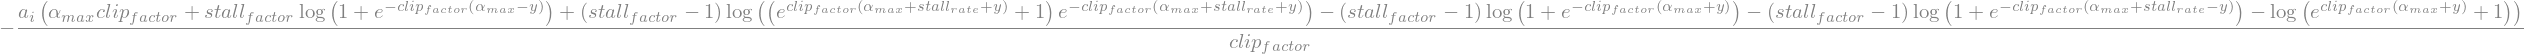

In [31]:
from sympy.abc import y
def ramp(x,corner,sharpness):
    return 1/sharpness*sym.ln(1+sym.exp(sharpness*(x+corner)))

def make_cl(x,stall_angle,stall_factor,c_l_0,sharpness):
    c_l = ramp(x,stall_angle,sharpness)
    c_l -= ramp(x,-stall_angle,sharpness)*stall_factor
    c_l += ramp(x,-(stall_angle+p.stall_rate),sharpness)*(stall_factor-1)
    c_l += ramp(-x,-(stall_angle),sharpness)*(stall_factor-1)
    c_l -= ramp(-x,-(stall_angle+p.stall_rate),sharpness)*(stall_factor-1)
    c_l -= stall_angle
    c_l *= c_l_0
    return c_l

c_l_func = lambda x: make_cl(x,p.alpha_max,p.stall_factor,p.a_i,p.clip_factor)
sym.simplify(make_cl(y,p.alpha_max,p.stall_factor,p.a_i,p.clip_factor))

In [32]:
# Main Wing Aero Forces 
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_flexural_frame,p.a_i,
                               alphadot = 0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               w_g = 0,
                               root_alpha = 0,
                                delta_alpha = tau_0,
                               alpha_zero = 0,
                               stall_angle = p.alpha_max,
                               c = p.c,
                                V = p.V,
                               c_d_max = p.c_dmax,
                               linear = True,
                                z_inverted=False,
                                c_l_func = lambda x: sym.simplify(c_l_func(x)))

# split Main Wing into segments
forces = []
for i in range(main_panels):
    seg_width = p.s_i/main_panels
    yi = seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_0:yi,p.a_i:p.a[i]})*seg_width)
    
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
wing_AeroForces = ef.ExternalForce(Q)

In [33]:
fwt_AeroForces = ef.BodyForce(p,hinge_frame,*p.F,False)

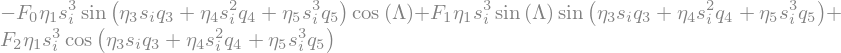

In [34]:
fwt_AeroForces.Q()[1]

In [36]:
#Create Composite force
CompositeForce = ef.CompositeForce([wing_AeroForces,fwt_AeroForces])
# Create the SYmbolic Model
sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_stiffness_ele,beam_mass_ele,fwt_ele,hinge_ele],CompositeForce)
# sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_stiffness_ele,fwt_ele,mass_ele],CompositeForce)

KeyboardInterrupt: 

In [19]:
test = hinge_frame.R_x(p.q[-1]).R_z(-p.Lambda).Translate(-p.x_f0+p.x_1,p.y_1,0)

In [25]:
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx1)
Jb = test.InvAdjoint()*test.ManipJacobian(p.q)
tt = Jb.T*M_fwt*Jb

In [10]:
d_z_s0 = z_0.diff(p.y_0).subs({p.y_0:p.s_i,p.x_0:p.x_f0})
d_d_z_s0 = d_z_s0.diff(me.dynamicsymbols._t)

dummy = sym.Function('d')(me.dynamicsymbols._t)
theta = sym.Symbol('theta')
alpha = sym.Symbol('alpha')

fwt_aoa = mf.GetAoA(alpha,0,p.Lambda,theta-dummy,dummy)
fwt_aoa = fwt_aoa.subs({alpha:(p.alpha_r+tau_s0),theta:p.q[-1]})
d_fwt_aoa = fwt_aoa.diff(me.dynamicsymbols._t)
d_fwt_aoa = d_fwt_aoa.subs({dummy.diff(me.dynamicsymbols._t):p.mu_d,dummy:p.mu})
fwt_aoa = fwt_aoa.subs({dummy:p.mu})

In [11]:
d_d_z_s0

In [12]:
sm = sm.subs({p.alpha_1:fwt_aoa,p.alphadot_1:d_fwt_aoa})

In [13]:
sm.to_matlab_file(p,'C:/Git/fwt_auto/+model/')

In [14]:
sm_lin = sm.subs({sym.sin(p.q[-1]):p.q[-1],sym.cos(p.q[-1]):1})

In [15]:
sm_lin.to_matlab_file(p,'C:/Git/scitech2022_post_flutter/+model_lin/')

In [16]:
# sm_lin = sm.linearise(p)

In [17]:
# sm_lin.to_matlab_file_linear(p,'C:/Git/fwt_auto/+model/')

In [18]:
file_dir ='C:/Git/fwt_auto/+model/'
func_name = 'd_z_s0'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(d_z_s0,p,func_name))
    
func_name = 'd_d_z_s0'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(d_d_z_s0,p,func_name))

In [19]:
# make function to plot wings
main_wing_surf = wing_frame.Transform_point([0,0,0])
fwt_surf = fwt_frame.Transform_point([0,0,0])

func_name = 'main_wing_surf'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(main_wing_surf,p,func_name))
    
func_name = 'fwt_surf'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(fwt_surf,p,func_name))

In [20]:
from time import time, ctime
def gen_octave(expr,func_name):  
    symbols = sorted([s.name for s in expr.free_symbols], key=lambda L: (L.lower(), L))
    print(symbols)
    # split expr into groups
    replacments, exprs = sym.cse(expr,symbols=(sym.Symbol(f'rep_{i}')for i in range(10000)))
    if isinstance(expr,tuple):
        expr = tuple(exprs)
    elif isinstance(expr,list):
        expr = exprs
    else:
        expr = exprs[0]      

    group_string = '%% create common groups\n\t'
    for variable, expression in replacments:
        group_string +=f'{variable} = {sym.printing.octave.octave_code(expression)};\n\t'

    # convert to octave string and covert states to vector form
    out = '%% create output \n\tout = ' + sym.printing.octave.octave_code(expr)

    # make the file pretty...
    out = out.replace(',',',...\n\t\t').replace(';',';...\n\t\t')

    file_sig = f'%{func_name.upper()} Auto-generated function from moyra\n\t'
    file_sig += f'%\n\t'
    file_sig += f'%\tCreated at : {ctime(time())} \n\t'
    file_sig += f'%\tCreated with : moyra https://pypi.org/project/moyra/\n\t'
    file_sig += f'%\n\t'

    # wrap output in octave function signature
    signature = f'function out = {func_name}('
    for s in symbols:
        signature +=f'{s},'
    signature = signature[:-1]+')\n\t'
    octave_string = signature + file_sig  + group_string + out + ';\nend'
    return octave_string

In [21]:
file_dir ='C:/Git/fwt_auto/+model/'
func_name = 'fwt_aoa'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(gen_octave(fwt_aoa,func_name))
func_name = 'd_fwt_aoa'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(gen_octave(d_fwt_aoa,func_name))

['alpha_r', 'eta_3', 'eta_4', 'eta_5', 'Lambda', 'mu', 's_i', 't']
['alpha_r', 'eta_3', 'eta_4', 'eta_5', 'Lambda', 'mu', 'mu_d', 's_i', 't']


In [22]:
func_name = 'C_l'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(gen_octave(c_l_func(p.alpha_1),func_name))

['a_i', 'alpha_1', 'alpha_max', 'clip_factor', 'stall_factor', 'stall_rate']


In [23]:
hinge_z = z_0.subs({p.y_0:p.s_i,p.x_0:p.x_f0})
hinge_twist = tau_0.subs({p.y_0:p.s_i,p.x_0:p.x_f0})
hinge_dihedral = d_z_s0
fold_angle = p.q[-1] - hinge_dihedral
local_aoa_root = dAlpha.subs({p.alpha_1:fwt_aoa,p.y_1:0})
local_aoa_mid = dAlpha.subs({p.alpha_1:fwt_aoa,p.y_1:p.s_f/2})
local_aoa_tip = dAlpha.subs({p.alpha_1:fwt_aoa,p.y_1:p.s_f})

In [24]:
file_dir ='C:/Git/fwt_auto/+model/'
func_names = ('hinge_z','hinge_twist','hinge_dihedral','fold_angle','local_aoa_root','local_aoa_mid','local_aoa_tip')
funcs = (hinge_z,hinge_twist,hinge_dihedral,fold_angle,local_aoa_root,local_aoa_mid,local_aoa_tip)
for fun,nam in zip(funcs,func_names):
    with open(file_dir+f"{nam}.m",'w') as file:
        file.write(sm._gen_octave(fun,p,nam))